In [1]:
# Third-party imports
from math import ceil
import numpy as np
import os
import vrplib

# Own imports
from src.new.acs import BWAS
from src.new.ants import FreeAnt
from src.new.display import DisplayModel
from src.new.helpers import create_directory, download_instance, get_distances_matrix
from src.new.heuristics import HeuristicModel
from src.new.machine_learning import KMeans
from src.new.metaheuristics import GeneralVNS, VariableNeighborhoodDescent
from src.new.models import VRPModel


In [2]:
# Parameters to handle the algorithm
%matplotlib inline

ALPHA = 1 # 0.75, 1, 1.05, 1.1, 1.25, 1.5, 1.75, 2
ANTS_NUM_RELATION = 2.5  # 1, 2
BETA = 2  # 2, 2.5, 3,  3.5
CANDIDATE_NODES_TYPE = 'best'  # None, 'best', 'random'
GAMMA = 3 # 1, 1.5 2
HEURISTICS_TO_USE = ['distance'] # ['distance'], ['distance', 'saving'], ['distance', 'capacity'],  ['distance', 'saving', 'capacity']
INITIAL_PHEROMONES_TYPE = 'tau_max' # 'tau_max', 'tau_zero'
ALL_SOLUTIONS_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS
ITERATION_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS, VariableNeighborhoodDescent
LAMBDA = 5
MAX_ITERATIONS = 200
MIN_ITERATIONS = 500
MUTATION_TYPE = None # None, 'rows', 'arcs'
P_M = 0.2 # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
PERCENT_ITERATIONS_RESTART = 0.3 # 0.1, 0.15, 0.2, 0.25, 0.3
PHEROMONES_ONLINE_UPDATE = False  # True, False
PHEROMONES_TYPE = 'mmas' # 'mmas', 'as'
PHEROMONES_UPDATE_TYPE = 'pseudo_g_best' # None, 'all_ants', 'it_best', 'g_best', 'pseudo_g_best'
PROBABILITIES_MATRIX_TYPE = 'classic'  # 'classic', 'normalized'
Q_0 = 0.3 # None, 0.8, 0.85, 0.9, 0.95
RHO = 0.2  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
SIGMA = 2  # 1, 2, 3, 4
SIMILARITY_OF_ARCS_STAGNATION = None # None, 0.5, 0.6, 0.7, 0.75, 0.8
SIMILARITY_OF_QUALITIES_STAGNATION = None # None, 0.885, 0.89, 0.9, 0.92, 0.95, 0.99
TARE_PERCENTAGE = 0.15

# Instance to solve
LIB = 'CMT'
INSTANCE = 'CMT5'

# Parameters to handle the display
PLOT_INSTANCE = False
PLOT_CLUSTERS = False
PLOT_SOLUTION = True
PLOT_MOST_USED_ARCS = False
PLOT_PHEROMONES_MATRIX = False


In [3]:
# Initialize everything
project_path = os.getcwd()
instance_file_exists = os.path.isfile(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')

if not instance_file_exists:
    create_directory(f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}/')
    success = download_instance(
        INSTANCE, f'{project_path}/instances/CVRPLIB/{LIB}/')

    if not success:
        raise Exception('Error downloading the instance')


instance = vrplib.read_instance(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')
solution = vrplib.read_solution(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.sol')

demands = instance['demand']
nodes = [node for node in range(len(demands))]
clients = nodes[1:]
max_capacity = instance['capacity']
matrix_coords = instance['node_coord']
k_optimal = ceil(sum(demands)/max_capacity)

optimal_cost = None
if solution['cost']:
    optimal_cost = solution['cost']
else:
    optimal_cost = float(instance['comment']) if instance['comment'] else None

errors = VRPModel.validate_instance(nodes, demands, max_capacity)
if errors:
    raise Exception(errors)

iterations = max(round(len(nodes), -2), MIN_ITERATIONS)
matrix_distances = get_distances_matrix(nodes, matrix_coords)

parameters_heuristics = {
    'demands': demands,
    'importance_capacity': LAMBDA,
    'importance_distances': BETA,
    'importance_savings': GAMMA,
    'matrix_coords': matrix_coords,
    'max_capacity': max_capacity,
    'nodes': nodes[:],
    'normalization': None,
}

heuristics = HeuristicModel(**parameters_heuristics)
matrix_heuristics = heuristics.get_heuristic_matrix(HEURISTICS_TO_USE)

parameters_kmeans = {
    'demands': np.array(demands),
    'k_optimal': k_optimal,
    'matrix_coords': matrix_coords[:],
    'matrix_distances': matrix_distances[:],
    'max_capacity': max_capacity,
    'nodes': nodes[:],
}

kmeans = KMeans(**parameters_kmeans)
best_constraint_clusters, clusters_arcs, best_cost, centroids, _, lst_clusters = kmeans.run()
clusters_reversed = lst_clusters[::-1]
best_clusters = clusters_reversed[:2]
best_clusters = best_clusters.append(best_constraint_clusters)

parameters_ants = {
    'alpha': ALPHA,
    'ants_num': ceil(len(clients) / ANTS_NUM_RELATION),
    'demands': demands,
    'ipynb': False,
    'k_optimal': k_optimal,
    'lst_clusters': [best_constraint_clusters],
    # 'lst_clusters': best_clusters,
    'matrix_coords': matrix_coords,
    'matrix_costs': matrix_distances,
    'matrix_heuristics': matrix_heuristics,
    'max_capacity': max_capacity,
    'max_iterations': min(iterations, MAX_ITERATIONS),
    'model_ant': FreeAnt,
    'model_ls_it': ITERATION_LOCAL_SEARCH_MODEL,
    'model_ls_solutions': ALL_SOLUTIONS_LOCAL_SEARCH_MODEL,
    'model_problem': VRPModel,
    'nodes': nodes,
    'p_m': P_M,
    'percent_arcs_limit': SIMILARITY_OF_ARCS_STAGNATION,
    'percent_iterations_restart':PERCENT_ITERATIONS_RESTART,
    'percent_quality_limit': SIMILARITY_OF_QUALITIES_STAGNATION,
    'pheromones_online_update': PHEROMONES_ONLINE_UPDATE,
    'q0': Q_0,
    'rho': RHO,
    'sigma': SIGMA,
    'tare': max_capacity * TARE_PERCENTAGE,
    'type_candidate_nodes': CANDIDATE_NODES_TYPE,
    'type_initial_pheromone': INITIAL_PHEROMONES_TYPE,
    'type_mutation': MUTATION_TYPE,
    'type_pheromones_model': PHEROMONES_TYPE,
    'type_pheromones_update': PHEROMONES_UPDATE_TYPE,
    'type_probabilities_matrix': PROBABILITIES_MATRIX_TYPE,
}


    > Iteration: 1/160
        - Unassigned nodes: [104 158], [3 3]
        - Best previous total cost: inf
        - New total cost: 3961.6198065657063

    > Iteration: 2/160
        - Unassigned nodes: [136], [16]
        - Best previous total cost: 3961.6198065657063
        - New total cost: 2006.9607493820936

    > Iteration: 3/160
        - Unassigned nodes: [], []
        - Best previous total cost: 2006.9607493820936
        - New total cost: 1898.3379981996193

    > Iteration: 4/160
        - Unassigned nodes: [ 69 134], [8 5]
        - Best previous total cost: 1898.3379981996193
        - New total cost: 1694.1317063293636

    > Iteration: 5/160
        - Unassigned nodes: [83 84], [17  6]
        - Best previous total cost: 1694.1317063293636
        - New total cost: 1752.9427880863216

    > Iteration: 6/160
        - Unassigned nodes: [162], [9]
        - Best previous total cost: 1694.1317063293636
        - New total cost: 1629.165650644143

    > Iteration: 7/160


In [4]:
# Render the problem

if PLOT_INSTANCE:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_problem(nodes, demands, matrix_coords, instance_name)


In [5]:
# Render the clusters
if PLOT_CLUSTERS:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_k_means_clusters(
        best_constraint_clusters, centroids, matrix_coords, instance_name)


In [6]:
# Run the algorithm

# results_list = []

# for _ in range(10):
#     bwas = BWAS(**parameters_ants)
#     results = bwas.solve()
#     results_list.append(results)

bwas = BWAS(**parameters_ants)
results = bwas.solve()



PARAMETERS
----------------------------------------
AS:
	alpha: 1
	ants_num: 80
	beta: 1
	demands: 200
	evaporation_rate: 0.8
	iterations_local_search: no
	k_optimal: 16
	lst_clusters: yes
	max_capacity: 200
	max_iterations: 200
	min_demand: 1, max_demand: 41, mean: 15.93
	model_ant: Free Ant
	nodes: 199
	rho: 0.2
	t_max: 0.00197678635177890279009393914577685791300609707832
	t_min: 0.00000030133819098749533147815391452561950558219905
	t_zero: 0.00039535727035578050380867920488014988222857937217
	tare: 30.0
	type_candidate_nodes: best
	type_pheromones_update: pseudo_g_best
	type_probabilities_matrix: classic
----------------------------------------
ACS:
	epsilon: 0.0025
	pheromones_local_update: no
	q0: 0.3
----------------------------------------
MMAS:
	delta: 0.5
	initial_pheromones_value: 0.001976786351778903
	p_best: 0.05
	percent_arcs_limit: None
	percent_quality_limit: None
	type_initial_pheromone: tau_max
----------------------------------------
BWAS:
	p_m: 0.2
	sigma: 2
	type_m

Global Best -> 1815.82625: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


-- Time elapsed: 88.92556953430176 --
Iterations when do restart: [60, 120]

BEST SOLUTION FOUND: (1815.826245688983, [[0, 6, 61, 188, 96, 33, 193, 195, 158, 198, 53, 190, 0], [0, 127, 87, 4, 125, 98, 29, 153, 79, 15, 154, 124, 20, 155, 173, 191, 0], [0, 112, 64, 28, 101, 156, 114, 142, 137, 89, 185, 62, 43, 136, 145, 0], [0, 95, 126, 81, 26, 100, 149, 51, 7, 132, 35, 180, 69, 177, 123, 0], [0, 93, 186, 22, 141, 91, 113, 68, 42, 143, 41, 90, 115, 86, 0], [0, 14, 133, 84, 134, 85, 164, 165, 38, 119, 77, 10, 169, 0], [0, 147, 146, 18, 73, 135, 92, 148, 163, 97, 161, 106, 3, 49, 116, 0], [0, 58, 27, 99, 179, 167, 102, 175, 34, 65, 60, 54, 152, 105, 66, 0], [0, 45, 111, 83, 13, 88, 37, 166, 138, 5, 59, 120, 0], [0, 76, 40, 130, 12, 50, 129, 71, 52, 150, 108, 178, 78, 0], [0, 16, 67, 159, 182, 63, 107, 24, 144, 74, 23, 183, 117, 0], [0, 48, 171, 172, 82, 121, 21, 122, 140, 94, 47, 36, 0], [0, 31, 131, 80, 189, 75, 162, 9, 39, 109, 57, 187, 32, 0], [0, 44, 55, 181, 72, 118, 56, 25, 110, 168

Optimal cost: 1291.289144
Best cost: 1815.826245688983
Difference %: 40.62


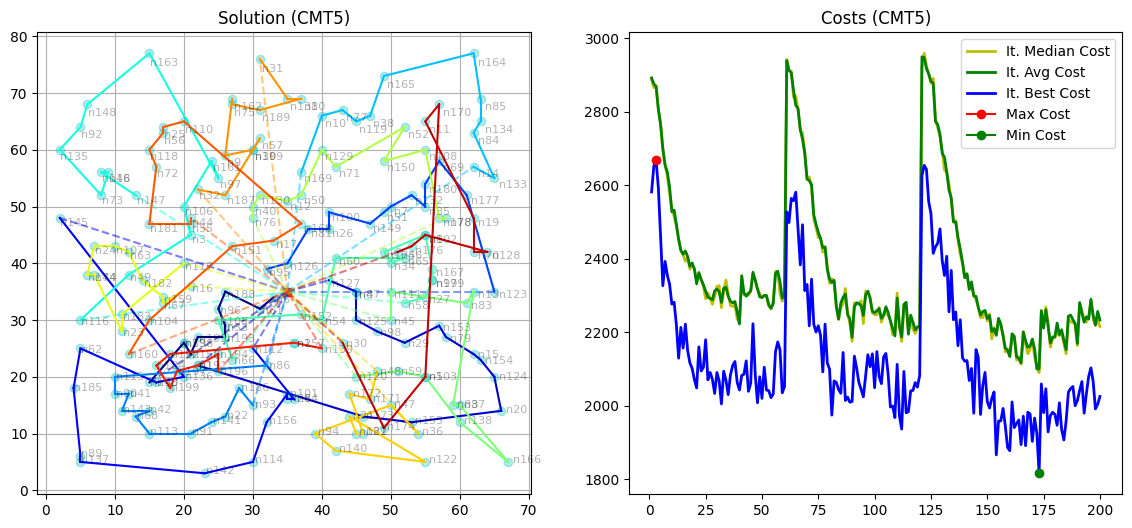

In [7]:
if optimal_cost:
    print(f'Optimal cost: {optimal_cost}')
    print(f'Best cost: {results["global_best_solution"]["cost"]}')
    print(
        f'Difference %: {round((results["global_best_solution"]["cost"] - optimal_cost) / optimal_cost * 100, 2)}')

if PLOT_SOLUTION:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_solution(results['global_best_solution'], matrix_coords, instance_name,
                                 results['best_solutions'], results['iterations_mean_costs'], results['iterations_median_costs'])


In [8]:
if PLOT_MOST_USED_ARCS:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.plot_most_used_arcs(
        results['iterations_best_solutions'], nodes, matrix_coords, instance_name)

In [9]:
if PLOT_PHEROMONES_MATRIX:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.plot_pheromones_matrices(results['pheromones_matrices'], instance_name, max_plots=50)